# Explorando MedMNIST com PyTorch - Cenário Multiclasse

Vamos seguir o _workflow_ padrão de _machine learning_ e _PyTorch_.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

**Objetivo:** trabalhar com alguns modelos de redes neurais em uma tarefa de classificação de imagens com a base MedMNIST.

**Base de Dados:** MedMNIST
* https://github.com/MedMNIST/MedMNIST/blob/main/README.md
* https://medmnist.com/

**Dataset selecionado** PathMNIST
- Número de classes: 9
  - ADI, adipose tissue;
  - BACK, background;
  - CRC, colorectal cancer;
  - DEB, debris;
  - HE, hematoxylin–eosin;
  - LYM, lymphocytes;
  - MUC, mucus; 
  - MUS, smooth muscle;
  - NORM, normal colon mucosa;
  - STR, cancer-associated stroma;
  - TUM, colorectal adenocarcinoma epithelium.

![](https://medmnist.com/assets/v2/imgs/PathMNIST.jpg)


In [2]:
# Instalação da versão mais atual da base MedMNIST+ (inclui as opções 64x64, 128x128 e 224x224 para os casos 2D)
%pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

  Cloning https://github.com/MedMNIST/MedMNIST.git to c:\users\levy\appdata\local\temp\pip-req-build-c_kse0re
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit a08267da64fc87c44e8ab52cf66e3030c43e3ede
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git 'C:\Users\Levy\AppData\Local\Temp\pip-req-build-c_kse0re'


### 1.1. Selecionamos um _dataset_ específico da base MedMNIST e exibimos algumas informações básicas

**Escolha:** PathMNIST
- Imagens de tecidos do cólon-reto para detecção de câncer / histologia


In [3]:
import medmnist
from medmnist import INFO, Evaluator

""" Caso Multiclasse --> Imagens do cólon-reto """
data_flag = 'pathmnist'
download = True

#A partir de um dicionário, recuperamos informações básicas do dataset escolhido
info = INFO[data_flag]

""" task = tipo de tarefa
    labels = dicionário que associa rótulos numéricos {0,1,...} ao nome das classes
    class_names = lista contendo os nomes das classes - obtida a partir do dicionário labels
    splits_info = dicionário que aponta a quantidade de amostras para cada partição dos dados  (train, val, test)
    n_classes = número de classes existentes """

task = info['task']
labels = info['label']
class_names_full = list(labels.values())

#específico para o dataset PathMNIST
class_names = ['ADI','BACK','DEB','LYM','MUC','MUS','NORM','STR','TUM']
splits_info = info['n_samples']
n_classes = len(info['label'])

#Extrai o nome da classe referente ao dataset escolhido para, depois, baixar as amostras das diferentes partições
DataClass = getattr(medmnist, info['python_class'])

print(f"Dataset selecionado: {data_flag}")
print(f"Tarefa: {task}")
print(f"Número de classes: {n_classes}")
print(f"Classes disponíveis: {class_names_full}")
print(f"Rótulos: {labels}")
print(f"\nDivisão dos dados: \n Treinamento: {splits_info['train']} amostras \n Validação: {splits_info['val']} amostras \n Teste: {splits_info['test']} amostras")


Dataset selecionado: pathmnist
Tarefa: multi-class
Número de classes: 9
Classes disponíveis: ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']
Rótulos: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}

Divisão dos dados: 
 Treinamento: 89996 amostras 
 Validação: 10004 amostras 
 Teste: 7180 amostras


### 1.2. Baixamos as amostras do _dataset_ escolhido

In [4]:
import torch
from pathlib import Path
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchmetrics
from torchmetrics import ConfusionMatrix, Accuracy, F1Score
from torchmetrics.classification import BinaryROC
from mlxtend.plotting import plot_confusion_matrix

""" Define as transformações a serem aplicadas nos dados """
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[.5], std=[.5])
])

#Carrega os subconjuntos já como torch.Tensor
train_data = DataClass(split='train', transform=data_transform, size=64, download=download)
val_data = DataClass(split='val', transform=data_transform, size=64, download=download)
test_data = DataClass(split='test', transform=data_transform, size=64, download=download)

""" Verificando os tamanhos das partições """
print(f"Treinamento: {len(train_data)}")
print(f"Validação: {len(val_data)}")
print(f"Teste: {len(test_data)}")


Using downloaded and verified file: C:\Users\Levy\.medmnist\pathmnist_64.npz
Using downloaded and verified file: C:\Users\Levy\.medmnist\pathmnist_64.npz
Using downloaded and verified file: C:\Users\Levy\.medmnist\pathmnist_64.npz
Treinamento: 89996
Validação: 10004
Teste: 7180


### 1.3. Carregando scripts 

Vamos aproveitar as ideias do código disponibilizado no repositório abaixo para baixar o conteúdo completo de um diretório dentro de um repositório do GitHub. 

**Requisito:** PyGithub instalado

**Fonte:** https://github.com/Nordgaren/Github-Folder-Downloader/tree/master

**Observação**: essa versão assume que o repositório é público. 

In [5]:
""" Código """

from github import Auth, Github, Repository, ContentFile
import requests, os

def download(c: ContentFile, out: str):
    r = requests.get(c.download_url)
    output_path = f'{out}/{c.path}'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'wb') as f:
        print(f'downloading {c.path} to {out}')
        f.write(r.content)


def download_folder(repo: Repository, folder: str, out: str, recursive: bool):
    contents = repo.get_contents(folder)
    for c in contents:
        if c.download_url is None:
            if recursive:
                download_folder(repo, c.path, out, recursive)
            continue
        download(c, out)
        
""" 
Criamos um objeto da classe GitHub para conseguir acesso a um repositório específico
Padrão do repositório: username/reponame
Exemplo: lboccato86/PyTorch_ML
"""
#auth = Auth.Login("lboccato86", "S@occer8684")
g = Github()
repo = g.get_repo('lboccato86/PyTorch_ML')

""" Usamos a função download_folder para baixar todo o conteúdo de um único diretório a
partir do repositório escolhido 
    folder = caminho a partir da raiz do repositório até o diretório alvo
"""
download_folder(repo = repo, folder = "scripts", out = ".", recursive=True)


downloading scripts/build_model.py to .
downloading scripts/engine.py to .
downloading scripts/utility_functions.py to .


### 1.4. Visualizando o balanceamento das classes

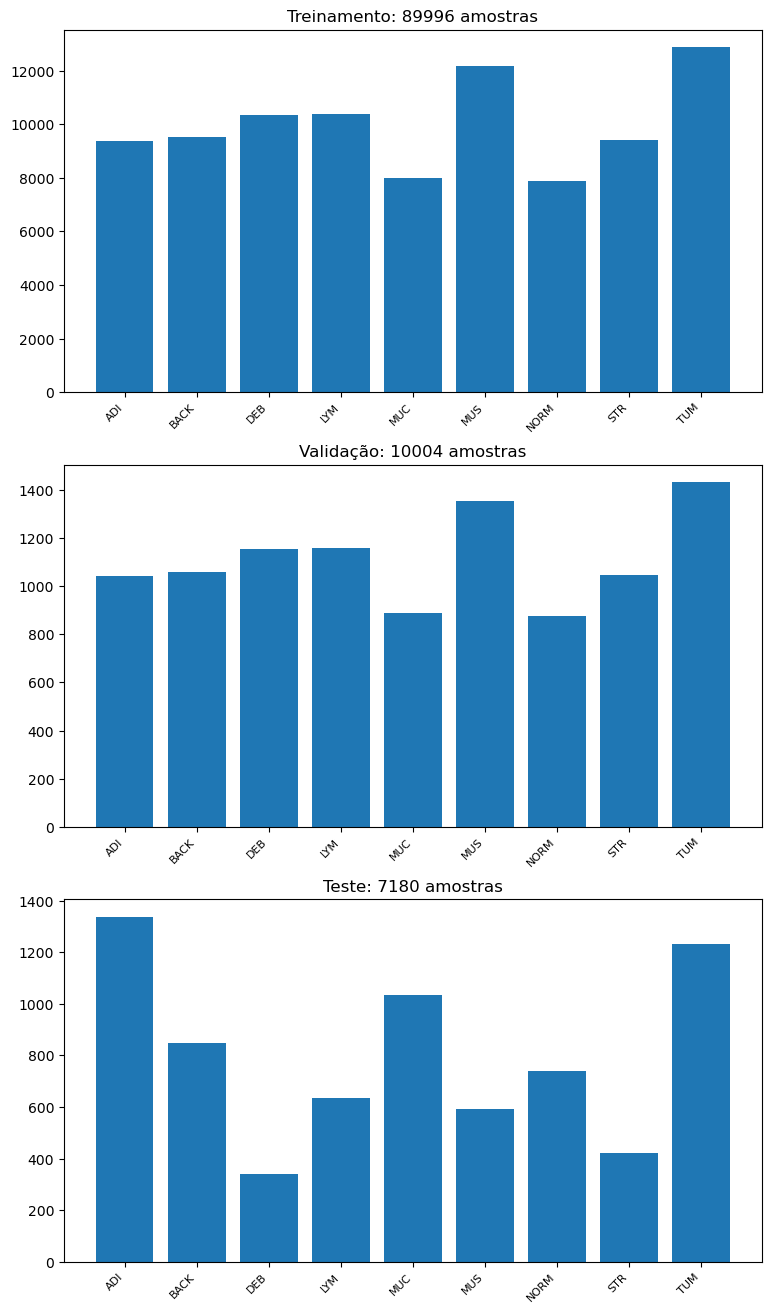

In [6]:
from scripts.utility_functions import check_class_balance, plot_loss_curves, predict_model, predict_model_dataloader

""" Verificando o balanceamento das classes nos conjuntos de treinamento, validação e teste """
fig = plt.figure(figsize=(9, 16))

fig.add_subplot(3,1,1)
dict_classes = check_class_balance(torch.from_numpy(train_data.labels),class_names)

plt.bar(x=dict_classes.keys(),height=dict_classes.values())
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.title(f"Treinamento: {len(train_data)} amostras")

fig.add_subplot(3,1,2)
dict_classes = check_class_balance(torch.from_numpy(val_data.labels),class_names)
plt.bar(x=dict_classes.keys(),height=dict_classes.values())
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.title(f"Validação: {len(val_data)} amostras")

fig.add_subplot(3,1,3)
dict_classes = check_class_balance(torch.from_numpy(test_data.labels),class_names)
plt.bar(x=dict_classes.keys(),height=dict_classes.values())
plt.xticks(rotation=45, ha="right",fontsize=8)
plt.title(f"Teste: {len(test_data)} amostras")

plt.show()   

### 1.5. Visualizando algumas amostras e suas características

**Nota:** o rótulo (label) de cada imagem vem no formato `int32`. Para buscarmos o nome da classe podemos usar o dicionário; contudo, precisamos converter esse número (sem ser um array, apenas um número mesmo) em `string`.

Solução:
```python 
str(label.item())
```


Shape/Formato de uma amostra: torch.Size([3, 64, 64]) - (channels, height, width)


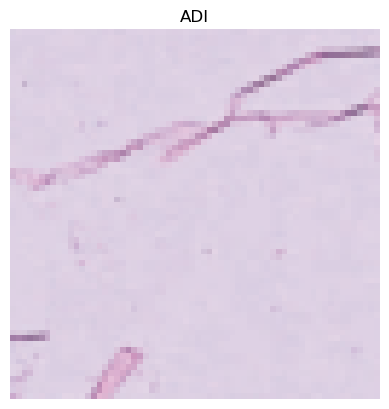

In [7]:
#Pegamos a primeira amostra do conjunto de treinamento
image,label = train_data[0]
print(f"Shape/Formato de uma amostra: {image.shape} - (channels, height, width)")

plt.imshow(image.squeeze().permute(1,2,0)) # image shape = [1, 64, 64] (colour channels, height, width) --> [64,64,1] (height, width, colour channels) [esperado pelo matplotlib]
plt.title(class_names[label.item()])
plt.axis(False);


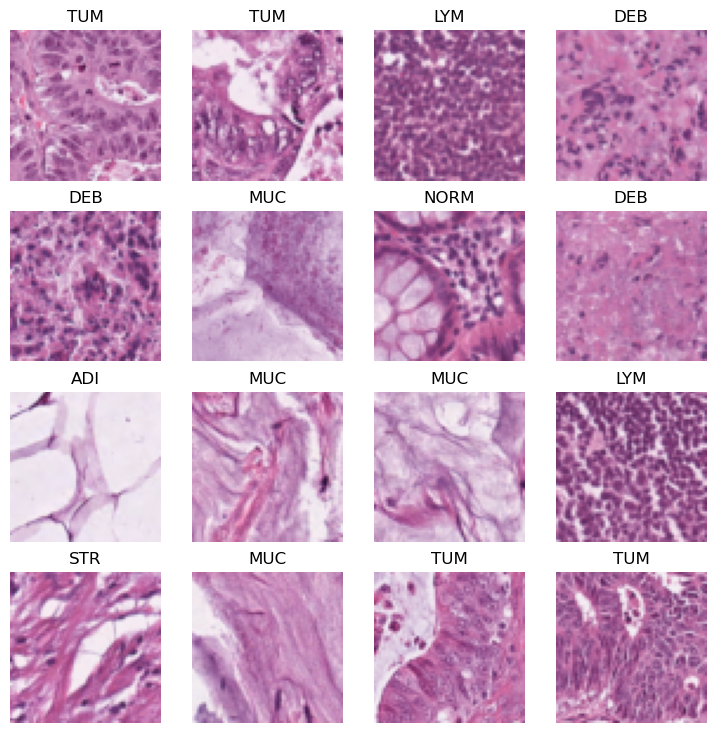

In [8]:
# Vamos exibir 16 figuras aleatórias da base de dados
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(0,rows*cols):

    #sorteia um índice de amostra aleatoriamente
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    #obtém a imagem e o seu rótulo
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i+1)

    plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
    plt.title(class_names[label.item()])
    plt.axis(False);




### 1.6. Preparando os dataloaders

In [9]:
# Tamanho do batch de treinamento
BATCH_SIZE = 32

# Converte o dataset de treinamento em objetos iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
                              batch_size=BATCH_SIZE, # how many samples per batch? 
                              shuffle=True # shuffle data every epoch?
)

# Let's check out what we've created
print(f"Dataloader: {train_dataloader}") 
print(f"Ao todo, temos {len(train_dataloader)} batches de {BATCH_SIZE} amostras")

# Converte o dataset de validação em dataloader
val_dataloader = DataLoader(val_data, # dataset to turn into iterable
                            batch_size=BATCH_SIZE, # colocamos todas as amostras em um único batch
                            shuffle=False # shuffle data every epoch?
)

print(f"Ao todo, temos {len(val_dataloader)} batches de {BATCH_SIZE} amostras")

# Converte o dataset de teste em dataloader
test_dataloader = DataLoader(test_data, # dataset to turn into iterable
                            batch_size=BATCH_SIZE, # colocamos todas as amostras em um único batch
                            shuffle=False # shuffle data every epoch?
)

print(f"Ao todo, temos {len(test_dataloader)} batches de {BATCH_SIZE} amostras")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001D80D7B3AC0>
Ao todo, temos 2813 batches de 32 amostras
Ao todo, temos 313 batches de 32 amostras
Ao todo, temos 225 batches de 32 amostras


## 2. Device-agnostic code

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 3. TinyVGG: Treinamento / Validação do model

### 3.1. Preparação do modelo

In [12]:
""" To do: usar engine, build_model para criar modelo e treinar """

from scripts.build_model import TinyVGG, MiniResNet

#Fixa a semente
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Cria uma instância da TinyVGG 
cnn_model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=8, 
                  output_shape=n_classes).to(device)

#Cria uma entrada aleatória com o shape esperado - (batch_size, channels, height, width)
#dummy_input = torch.rand((1,3,64,64))

#alimenta o modelo com a entrada para verificar a dimensão na entrada da parte 'classifier'
#cnn_model(dummy_input.to(device=device))

#exibe o resumo da arquitetura criada
summary(cnn_model, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 9]                    --
├─Sequential: 1-1                        [1, 8, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            224
│    └─ReLU: 2-2                         [1, 8, 64, 64]            --
│    └─Conv2d: 2-3                       [1, 8, 64, 64]            584
│    └─ReLU: 2-4                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-5                    [1, 8, 32, 32]            --
├─Sequential: 1-2                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-6                       [1, 8, 32, 32]            584
│    └─ReLU: 2-7                         [1, 8, 32, 32]            --
│    └─Conv2d: 2-8                       [1, 8, 32, 32]            584
│    └─ReLU: 2-9                         [1, 8, 32, 32]            --
│    └─MaxPool2d: 2-10                   [1, 8, 16, 16]            --
├─Sequentia

### 4.2. Loss, Optimizer e Execução do loop de treinamento

In [13]:
from scripts.engine import train

#Classificação multi-classe: Entropia cruzada
if task == "binary-class":
    loss_fn = nn.BCEWithLogitsLoss()
else:
    loss_fn = nn.CrossEntropyLoss()

#Algoritmo de otimização
optimizer = torch.optim.Adam(params=cnn_model.parameters(), lr=0.001)

# Define as random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Define o número máximo de épocas de treinamento
NUM_EPOCHS = 100

# Define a paciência (Early stopping)
PATIENCE = 20

# Define o caminho e o nome do arquivo que conterá os pesos/parâmetros salvos do modelo
MODEL_PATH = Path("models/")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "TinyVGG_pathMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Define a métrica de avaliação adicional a ser monitorada/computada durante o treinamento
if task == "binary-class":
    acc_metric = Accuracy(task='binary').to(device)
elif task == "multi-class":
    acc_metric = Accuracy(task='multiclass',num_classes=n_classes).to(device)

# Inicializa o temporizador
from timeit import default_timer as timer 
start_time = timer()

# Treinamento da CNN
cnn_results = train(model=cnn_model, 
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=NUM_EPOCHS,
                    patience=PATIENCE,
                    model_save_path=MODEL_SAVE_PATH,
                    device=device,
                    task=task,
                    metric = acc_metric)

# Encerra o temporizados e mede quanto tempo levou o treinamento completo 
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.1326 | train_acc: 0.5754 | val_loss: 1.0546 | val_acc: 0.6063
Epoch: 1 | train_loss: 0.8347 | train_acc: 0.6901 | val_loss: 0.8474 | val_acc: 0.6829
Epoch: 2 | train_loss: 0.7218 | train_acc: 0.7304 | val_loss: 0.6568 | val_acc: 0.7669
Epoch: 3 | train_loss: 0.6002 | train_acc: 0.7840 | val_loss: 0.5465 | val_acc: 0.8027
Epoch: 4 | train_loss: 0.5277 | train_acc: 0.8132 | val_loss: 0.4738 | val_acc: 0.8375
Epoch: 5 | train_loss: 0.4760 | train_acc: 0.8314 | val_loss: 0.4396 | val_acc: 0.8473
Epoch: 6 | train_loss: 0.4324 | train_acc: 0.8478 | val_loss: 0.4672 | val_acc: 0.8357
Epoch: 7 | train_loss: 0.4032 | train_acc: 0.8582 | val_loss: 0.4822 | val_acc: 0.8311
Epoch: 8 | train_loss: 0.3801 | train_acc: 0.8666 | val_loss: 0.3714 | val_acc: 0.8721
Epoch: 9 | train_loss: 0.3590 | train_acc: 0.8736 | val_loss: 0.3930 | val_acc: 0.8639
Epoch: 10 | train_loss: 0.3471 | train_acc: 0.8770 | val_loss: 0.3887 | val_acc: 0.8660
Epoch: 11 | train_loss: 0.3303 | train_acc

### 4.3. Avaliação do progresso do treinamento

Vamos exibir as curvas da função custo e de acurácia para os conjuntos de treinamento e de validação ao longo das épocas

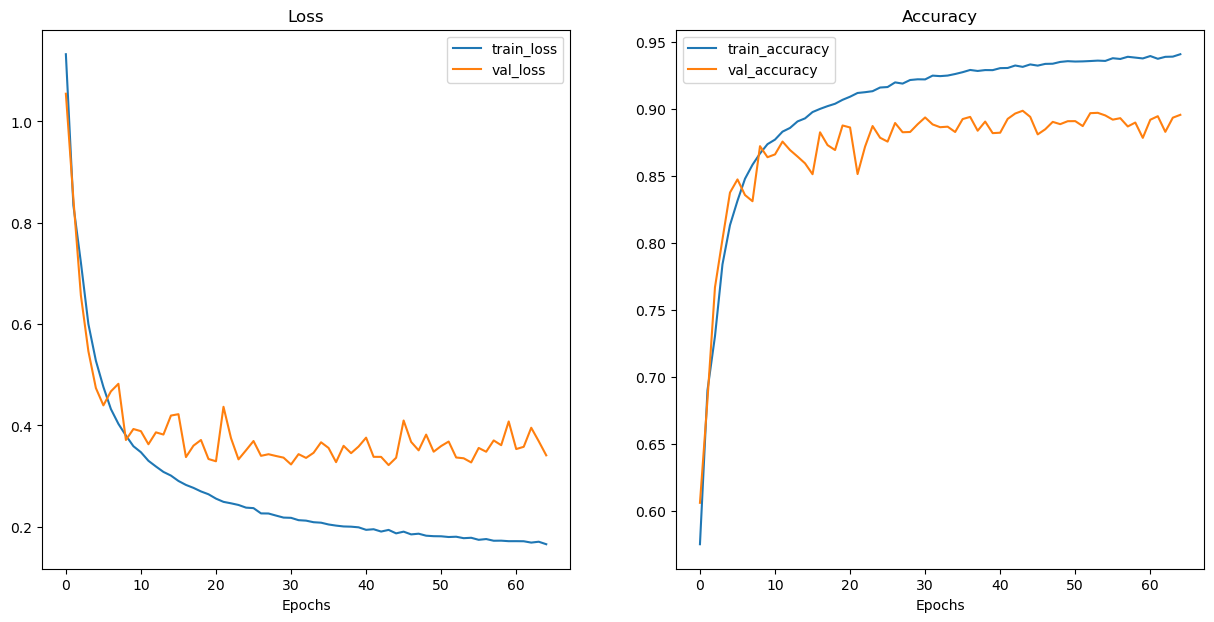

In [14]:
plot_loss_curves(cnn_results)

### 4.4. Aplicação do modelo treinado ao conjunto de teste

#### 4.4.1. Carregando modelo salvo para continuar com a avaliação dos resultados

Ao retomar esse notebook, a fim de evitar o re-treinamento de um modelo, carregamos o arquivo com os pesos que foram salvos durante o último treinamento bem-sucedido.

Para isto, **basta rodar o trecho de código abaixo**:

```python 


# Define o caminho e o nome do arquivo que conterá os pesos/parâmetros salvos do modelo
MODEL_PATH = Path("models/")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "TinyVGG_pathMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Cria uma instância da TinyVGG 
cnn_model = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=8, 
                  output_shape=n_classes).to(device)

cnn_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

cnn_model.to(device)

```

Acurácia da rede no conjunto de teste: 82.02%
F1-score da rede no conjunto de teste: 0.820


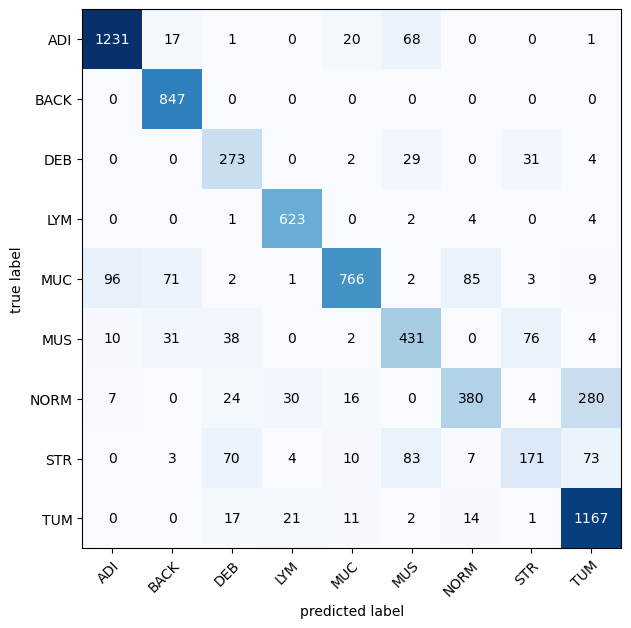

In [16]:
#Obtém as saídas (logits) da rede treinada para o conjunto de teste e os respectivos labels estimados
cnn_pred_logits_test,cnn_pred_labels_test,y_test = predict_model_dataloader(model=cnn_model,dataloader=test_dataloader,task=task,device=device,n_classes=n_classes)

""" Monta a matriz de confusão 
    Cuidado: todos os tensores e o objeto ConfusionMatrix devem estar no mesmo device
"""

#pega o tensor completo com todos os labels do conjunto inteiro de teste
y_test = torch.from_numpy(test_data.labels)

confmat = ConfusionMatrix(num_classes=n_classes, task='multiclass').to(device)
confmat_tensor = confmat(preds=cnn_pred_logits_test,
                         target=y_test.squeeze().to(device))

# 3. Exibe a matriz de confusão usando a função do pacote mlxtend
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#Cria métricas e as coloca no mesmo device
torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=n_classes).to(device)
torchmetrics_f1 = F1Score(task='multiclass',num_classes=n_classes).to(device)

#Calculate accuracy
acc_test = torchmetrics_accuracy(preds=cnn_pred_logits_test, target=y_test.squeeze().to(device))
f1_test = torchmetrics_f1(preds=cnn_pred_logits_test, target=y_test.squeeze().to(device))
print(f"Acurácia da rede no conjunto de teste: {acc_test*100:.2f}%")
print(f"F1-score da rede no conjunto de teste: {f1_test:.3f}")

### 4.5. Classificação de amostras aleatórias do conjunto de teste

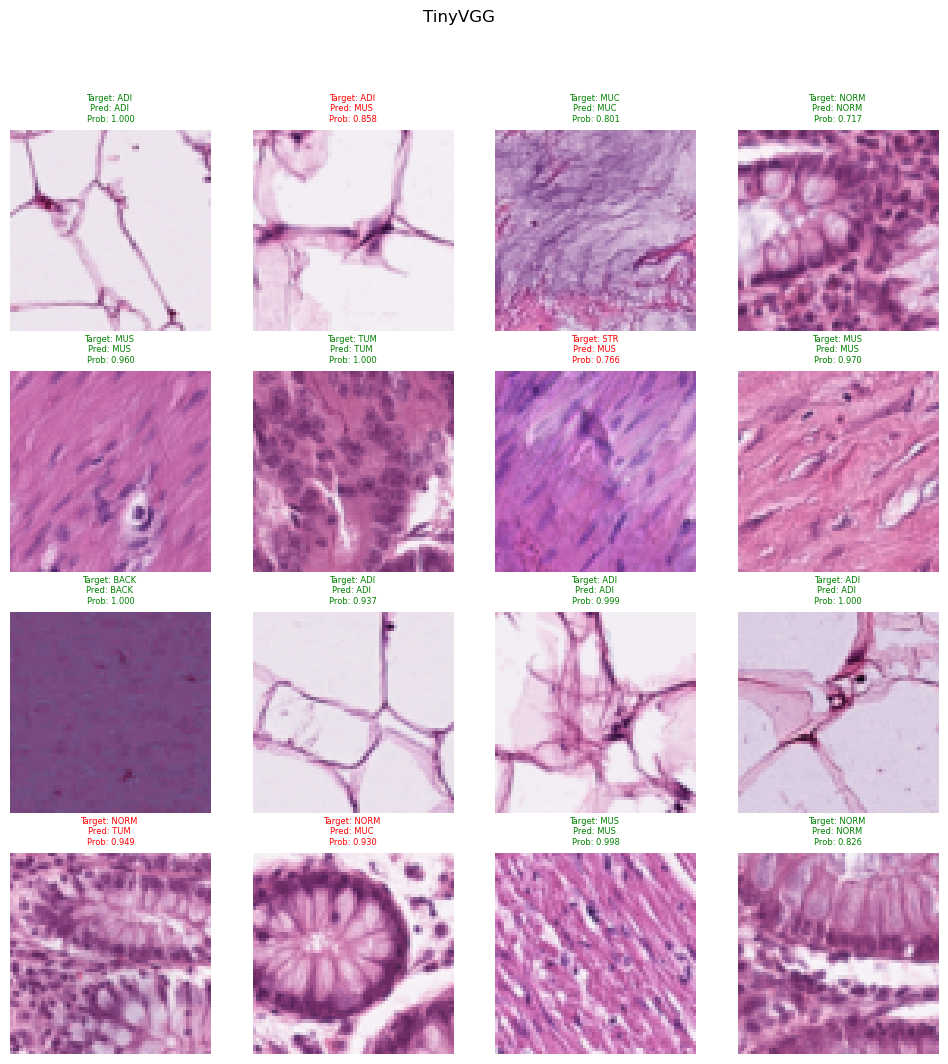

In [17]:
# Vamos exibir 16 figuras aleatórias da base de dados

fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4

for i in range(0,rows*cols):

    #sorteia um índice de amostra aleatoriamente
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    #obtém a imagem e o seu rótulo
    img, label = test_data[random_idx]

    """ obtém os logits e o rótulo predito pela rede treinada 
        Detalhe: temos que acrescentar a dim = 0 (referente ao batch_size) """
    cnn_logits,cnn_pred_label = predict_model(model=cnn_model, X=img.unsqueeze(dim=0),task="multi-class",device=device)

    fig.add_subplot(rows, cols, i+1)

    #exibe a imagem
    plt.imshow(img.squeeze().permute(1,2,0))

    #formata o título para exibir o nome da classe estimada e a probabilidade associada 
    nome_classe_estim = class_names[cnn_pred_label.type(torch.int).cpu().item()]

    title = f"Target: {class_names[label.item()]} \nPred: {nome_classe_estim} \nProb: {torch.softmax(cnn_logits,dim=1).cpu().max():.3f}"

    if cnn_pred_label.item() == label.item(): 
        plt.title(title,fontdict={"fontsize": 6, "color": 'g'})
    else:
        plt.title(title,fontdict={"fontsize": 6, "color": 'r'})
    plt.suptitle("TinyVGG")
    plt.axis(False);


## 5. MiniResNet: Treinamento / Validação

### 5.1. Preparação do modelo e treinamento

In [18]:
#Fixa a semente
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Cria uma instância da TinyVGG 
resnet_model = MiniResNet(input_shape=3, # number of color channels (3 for RGB) 
                          base_kernel_units=8, 
                          output_shape=n_classes).to(device)

#exibe o resumo da arquitetura criada
summary(resnet_model, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
MiniResNet                               [1, 9]                    --
├─Sequential: 1-1                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-1                       [1, 8, 32, 32]            608
│    └─BatchNorm2d: 2-2                  [1, 8, 32, 32]            16
│    └─ReLU: 2-3                         [1, 8, 32, 32]            --
│    └─MaxPool2d: 2-4                    [1, 8, 16, 16]            --
├─Sequential: 1-2                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-5                       [1, 8, 16, 16]            584
│    └─BatchNorm2d: 2-6                  [1, 8, 16, 16]            16
│    └─ReLU: 2-7                         [1, 8, 16, 16]            --
├─Sequential: 1-3                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-8                       [1, 8, 16, 16]            584
│    └─BatchNorm2d: 2-9                  [1, 8, 16, 16]            16
├─ReLU: 1-4 

### 5.2 Loss, Optimizer e Execução do loop de treinamento

In [19]:
#Classificação multi-classe: Entropia cruzada
if task == "binary-class":
    loss_fn = nn.BCEWithLogitsLoss()
else:
    loss_fn = nn.CrossEntropyLoss()

#Algoritmo de otimização
optimizer = torch.optim.Adam(params=resnet_model.parameters(), lr=0.001)

# Define as random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Define o número máximo de épocas de treinamento
NUM_EPOCHS = 100

# Define a paciência (Early stopping)
PATIENCE = 20

# Define o caminho e o nome do arquivo que conterá os pesos/parâmetros salvos do modelo
MODEL_PATH = Path("models/")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "MiniResNet_pathMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Define a métrica de avaliação adicional a ser monitorada/computada durante o treinamento
if task == "binary-class":
    acc_metric = Accuracy(task='binary').to(device)
elif task == "multi-class":
    acc_metric = Accuracy(task='multiclass',num_classes=n_classes).to(device)

# Inicializa o temporizador
from timeit import default_timer as timer 
start_time = timer()

# Treinamento da CNN
resnet_results = train(model=resnet_model, 
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn, 
                    epochs=NUM_EPOCHS,
                    patience=PATIENCE,
                    model_save_path=MODEL_SAVE_PATH,
                    device=device,
                    task=task,
                    metric = acc_metric)

# Encerra o temporizados e mede quanto tempo levou o treinamento completo 
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 0.7323 | train_acc: 0.7418 | val_loss: 0.8338 | val_acc: 0.7004
Epoch: 1 | train_loss: 0.4786 | train_acc: 0.8269 | val_loss: 0.7951 | val_acc: 0.7227
Epoch: 2 | train_loss: 0.4046 | train_acc: 0.8536 | val_loss: 1.1756 | val_acc: 0.5858
Epoch: 3 | train_loss: 0.3653 | train_acc: 0.8685 | val_loss: 0.3992 | val_acc: 0.8577
Epoch: 4 | train_loss: 0.3362 | train_acc: 0.8799 | val_loss: 0.3813 | val_acc: 0.8574
Epoch: 5 | train_loss: 0.3139 | train_acc: 0.8891 | val_loss: 0.4925 | val_acc: 0.8232
Epoch: 6 | train_loss: 0.2925 | train_acc: 0.8970 | val_loss: 0.9351 | val_acc: 0.7189
Epoch: 7 | train_loss: 0.2788 | train_acc: 0.9023 | val_loss: 0.8992 | val_acc: 0.6789
Epoch: 8 | train_loss: 0.2729 | train_acc: 0.9044 | val_loss: 0.3521 | val_acc: 0.8793
Epoch: 9 | train_loss: 0.2646 | train_acc: 0.9072 | val_loss: 0.3392 | val_acc: 0.8797
Epoch: 10 | train_loss: 0.2547 | train_acc: 0.9112 | val_loss: 0.8298 | val_acc: 0.7753
Epoch: 11 | train_loss: 0.2480 | train_acc

### 5.3. Avaliação do progresso do treinamento

Vamos exibir as curvas da função custo e de acurácia para os conjuntos de treinamento e de validação ao longo das épocas

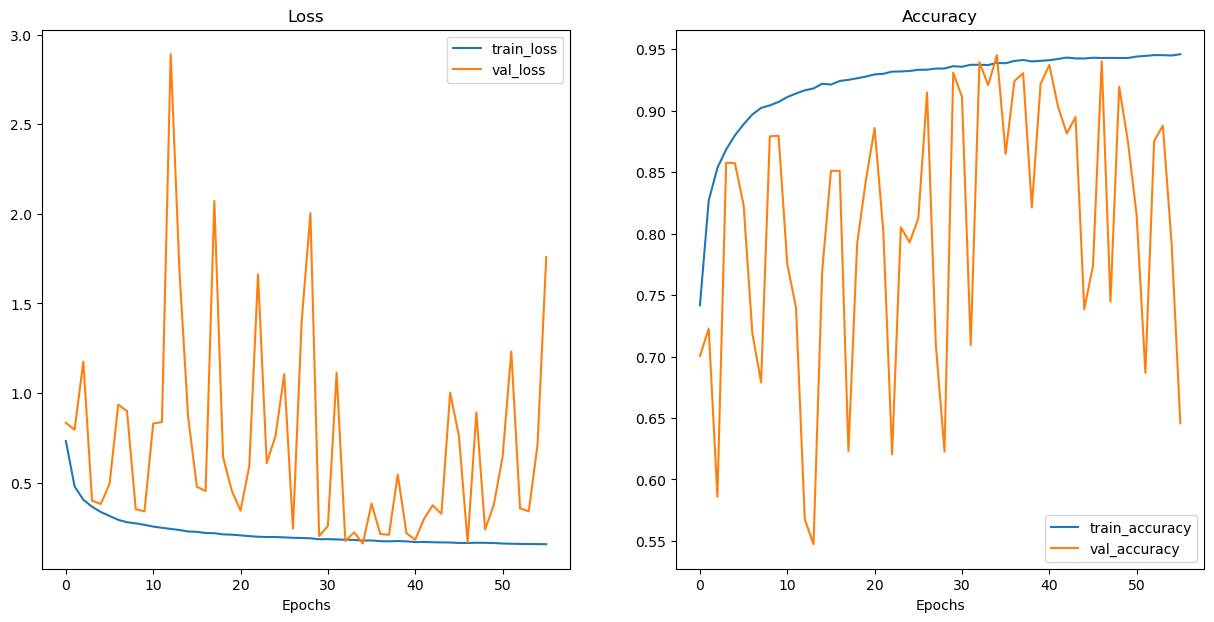

In [20]:
plot_loss_curves(resnet_results)

### 5.4. Aplicação da ResNet treinada ao conjunto de teste

Acurácia da rede no conjunto de teste: 87.14%
F1-score da rede no conjunto de teste: 0.871


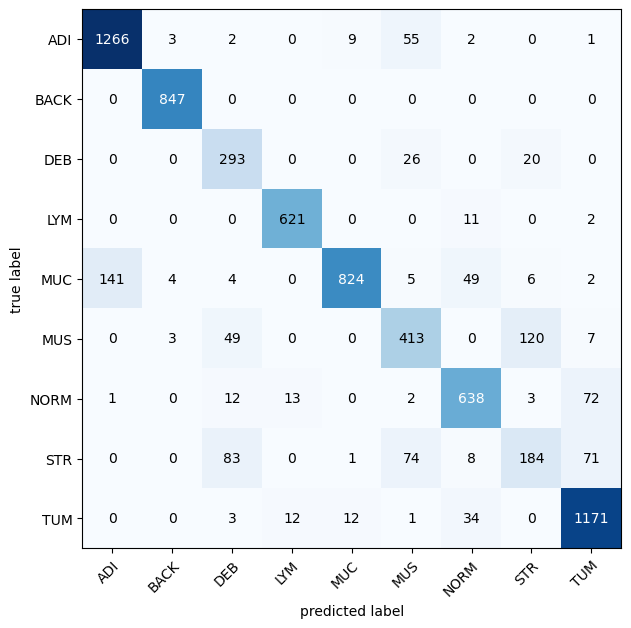

In [21]:
#Obtém as saídas (logits) da rede treinada para o conjunto de teste e os respectivos labels estimados
resnet_pred_logits_test,resnet_pred_labels_test,y_test = predict_model_dataloader(model=resnet_model,dataloader=test_dataloader,task=task,device=device,n_classes=n_classes)

""" Monta a matriz de confusão 
    Cuidado: todos os tensores e o objeto ConfusionMatrix devem estar no mesmo device
"""

#pega o tensor completo com todos os labels do conjunto inteiro de teste
y_test = torch.from_numpy(test_data.labels)

confmat = ConfusionMatrix(num_classes=n_classes, task='multiclass').to(device)
confmat_tensor = confmat(preds=resnet_pred_logits_test,
                         target=y_test.squeeze().to(device))

# 3. Exibe a matriz de confusão usando a função do pacote mlxtend
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#Cria métricas e as coloca no mesmo device
torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=n_classes).to(device)
torchmetrics_f1 = F1Score(task='multiclass',num_classes=n_classes).to(device)

#Calculate accuracy
acc_test = torchmetrics_accuracy(preds=resnet_pred_logits_test, target=y_test.squeeze().to(device))
f1_test = torchmetrics_f1(preds=resnet_pred_logits_test, target=y_test.squeeze().to(device))
print(f"Acurácia da rede no conjunto de teste: {acc_test*100:.2f}%")
print(f"F1-score da rede no conjunto de teste: {f1_test:.3f}")


### 5.5. Classificação de amostras do conjunto de teste

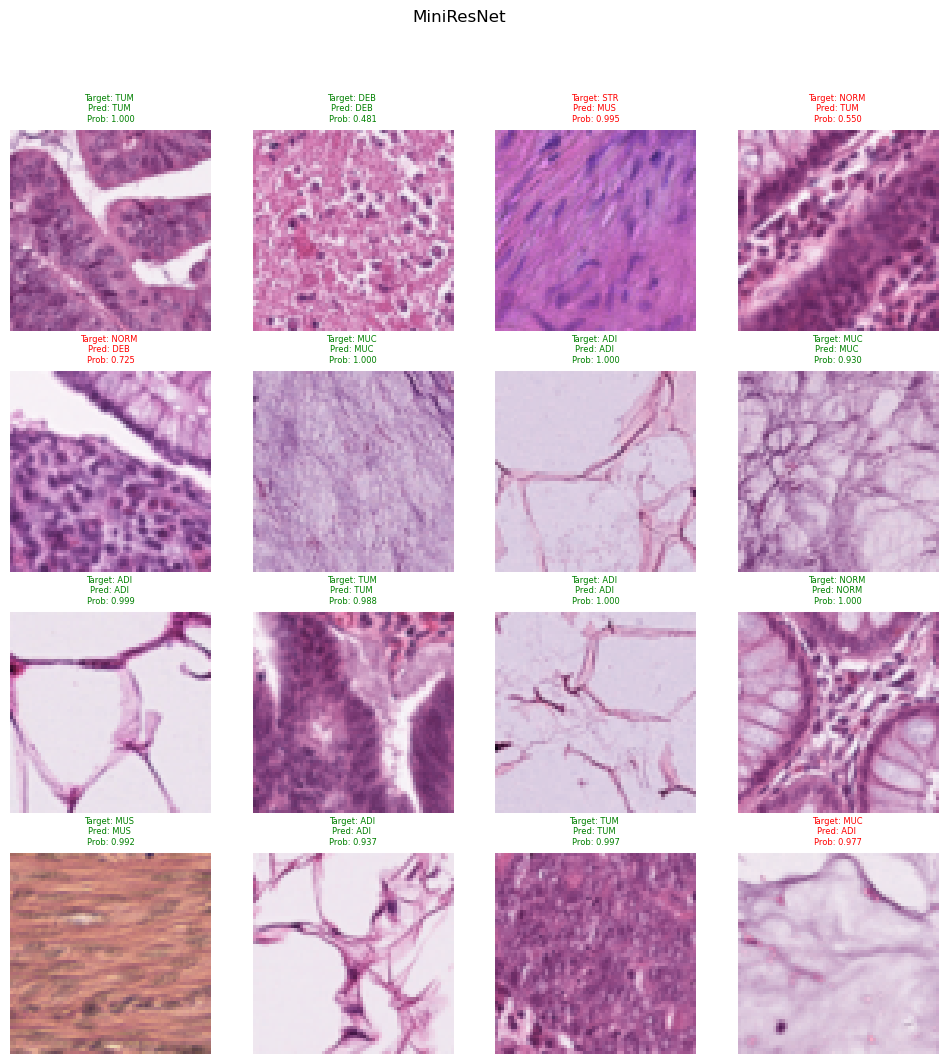

In [23]:
# Vamos exibir 16 figuras aleatórias da base de dados

fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4

for i in range(0,rows*cols):

    #sorteia um índice de amostra aleatoriamente
    random_idx = torch.randint(0, len(test_data), size=[1]).item()
    #obtém a imagem e o seu rótulo
    img, label = test_data[random_idx]

    """ obtém os logits e o rótulo predito pela rede treinada 
        Detalhe: temos que acrescentar a dim = 0 (referente ao batch_size) """
    resnet_logits,resnet_pred_label = predict_model(model=resnet_model, X=img.unsqueeze(dim=0),task="multi-class",device=device)

    fig.add_subplot(rows, cols, i+1)

    #exibe a imagem
    plt.imshow(img.squeeze().permute(1,2,0))

    #formata o título para exibir o nome da classe estimada e a probabilidade associada 
    nome_classe_estim = class_names[resnet_pred_label.type(torch.int).cpu().item()]

    title = f"Target: {class_names[label.item()]} \nPred: {nome_classe_estim} \nProb: {torch.softmax(resnet_logits,dim=1).cpu().max():.3f}"

    if resnet_pred_label.item() == label.item():
        plt.title(title,fontdict={"fontsize": 6, "color": 'g'})
    else:
        plt.title(title,fontdict={"fontsize": 6, "color": 'r'})
    plt.suptitle("MiniResNet")
    plt.axis(False);
